# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour image segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```

## What to do?

* Complete and run the code using `jupyter-lab` or `jupyter-notebook` to get the results.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* Instead of clicking the Export button, you can also run the following command instead: `jupyter nbconvert coursework.ipynb --to pdf`

* If Jupyter complains about some problems in exporting, it is likely that pandoc (https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry.

* If Jupyter-lab does not work for you at the end, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [ ]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

## 1. Download and visualise the imaging dataset.

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [ ]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2023-03-02 20:54:31--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz [following]
--2023-03-02 20:54:32--  https://www.dropbox.com/s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc74ab88c474b0f21cb0ef4fdb78.dl.dropboxusercontent.com/cd/0/inline/B3gAUmkqDHP5LjXN6IJ7jvLQ3qDUk_TM9fu0w-PzWnICfgCKRMKFh9kfmsU-lZOorLAM8iAnQ-APEEP4L3_4-95zWqyklh21LKdYE7X7VIBpuLLcBQkBeaKPdcu-wPef8JzcH0CRs1w2I4sfP-eQ93CLAEPWpJC7PcyUu8zxP9Qxww/file# [following]
--2023-03-02 20:54:32--  https://uc74ab88c474b0f21cb0ef4fdb78.dl.dropboxusercontent.com/cd/0/inline/B3gAUmkqDHP5LjXN6IJ7jvLQ3qDUk

## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

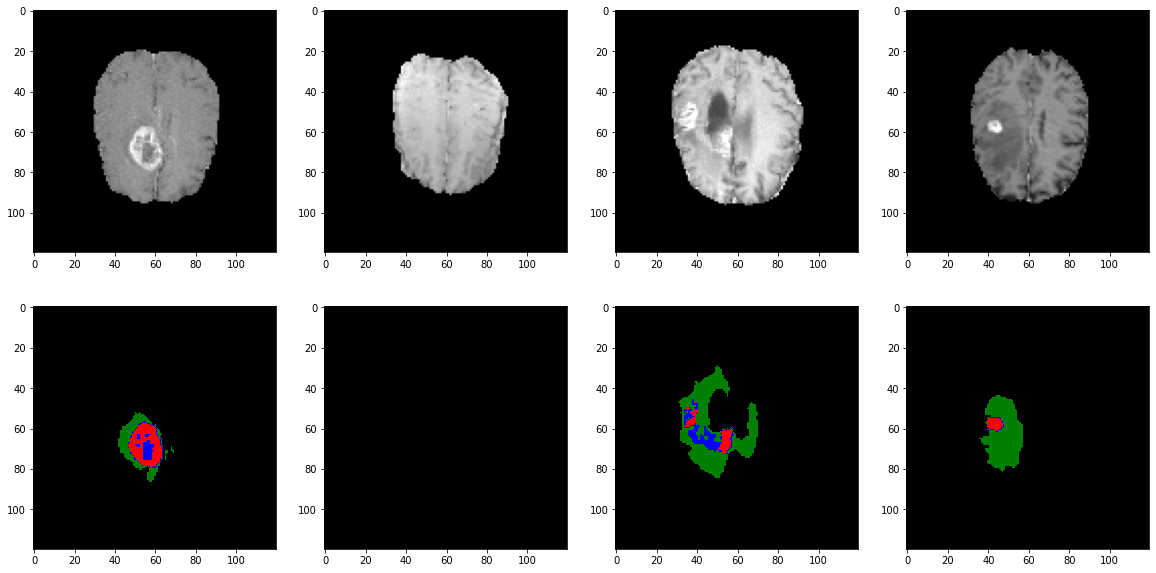

In [ ]:
### Insert your code ###
training_images = os.listdir("./Task01_BrainTumour_2D/training_images")
random_images = random.sample(training_images, 4)

random_training_images = [imageio.imread(os.path.join("./Task01_BrainTumour_2D/training_images", f)) for f in random_images]
random_training_labels = [imageio.imread(os.path.join("./Task01_BrainTumour_2D/training_labels", f)) for f in random_images]

training_image_cmap = 'gray'
training_label_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])

fig, axs = plt.subplots(2, 4, figsize = (20, 10))

for i in range(4):
    axs[0, i].imshow(random_training_images[i], cmap = training_image_cmap)
    axs[1, i].imshow(random_training_labels[i], cmap = training_label_cmap)

plt.show()

### End of your code ###

## 2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [ ]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        ### Insert your code ###
        random_indices = random.sample(range(len(self.images)), batch_size)

        for index in random_indices:
          image, label = self[index]
          images.append(np.expand_dims(image, axis=0))
          labels.append(label)

        images = np.concatenate(images, axis=0)
        images = np.expand_dims(images, axis=1)
        labels = np.asarray(labels, dtype=np.int64)
        ### End of your code ###
        return images, labels

## 3. Build a U-net architecture.

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [ ]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )
        
        # Decoder path
        ### Insert your code ### 

        # upsampling using 2x2 kernel
        self.upconv1 = nn.ConvTranspose2d(n, int(n / 2), kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Sequential(
            # conv 3x3 followed by relu 
            nn.Conv2d(n, int(n / 2), kernel_size=3, padding=1),
            nn.BatchNorm2d(int(n / 2)),
            nn.ReLU(),
            # conv 3x3 followed by relu 
            nn.Conv2d(int(n / 2), int(n / 2), kernel_size=3, padding=1),
            nn.BatchNorm2d(int(n / 2)),
            nn.ReLU()
        )

        n = int(n / 2)  # 64
        # upsampling using 2x2 kernel
        self.upconv2 = nn.ConvTranspose2d(n, int(n / 2), kernel_size=4, stride=2, padding=1)
        self.conv6 = nn.Sequential(
            # conv 3x3 followed by relu
            nn.Conv2d(n, int(n / 2), kernel_size=3, padding=1),
            nn.BatchNorm2d(int(n / 2)),
            nn.ReLU(),
            # conv 3x3 followed by relu
            nn.Conv2d(int(n / 2), int(n / 2), kernel_size=3, padding=1),
            nn.BatchNorm2d(int(n / 2)),
            nn.ReLU()
        )

        n = int(n / 2)  # 32
        # upsampling using 2x2 kernel
        self.upconv3 = nn.ConvTranspose2d(n, int(n / 2), kernel_size=4, stride=2, padding=1)
        self.conv7 = nn.Sequential(
            # conv 3x3 followed by relu
            nn.Conv2d(n, int(n / 2), kernel_size=3, padding=1),
            nn.BatchNorm2d(int(n / 2)),
            nn.ReLU(),
            # conv 3x3 followed by relu
            nn.Conv2d(int(n / 2), int(n / 2), kernel_size=3, padding=1),
            nn.BatchNorm2d(int(n / 2)),
            nn.ReLU()
        )

        n = int(n / 2)  # 16

        # final output layer
        self.conv8 = nn.Conv2d(n, output_channel, kernel_size=1)


        ### End of your code ###

    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        ### Insert your code ###

        # upsampling
        x = self.upconv1(x)
        # skip connections
        x = torch.cat([x, conv3_skip], dim=1)
        # convolutions
        x = self.conv5(x)

        # upsampling
        x = self.upconv2(x)
        # skip connections
        x = torch.cat([x, conv2_skip], dim=1)
        # convolutions
        x = self.conv6(x)

        # upsampling
        x = self.upconv3(x)
        # skip connections
        x = torch.cat([x, conv1_skip], dim=1)
        # convolutions
        x = self.conv7(x)

        # final output layer
        x = self.conv8(x)
        
        ### End of your code ###
        return x

## 4. Train the segmentation model.

In [ ]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)

    # Perform optimisation and print out the training loss
    ### Insert your code ###
    # remove gradients
    optimizer.zero_grad()

    # resize input tensor to match size of target tensor
    logits = F.interpolate(logits, size=(120, 120), mode='bilinear', align_corners=True)

    # calculate training loss
    training_loss = criterion(logits, labels)

    # calculate gradients
    training_loss.backward()

    # update parameters
    optimizer.step()
    ### End of your code ###

    # Evaluate
    if it % 100 == 0:
        print(f'training loss = {training_loss}')
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            ### Insert your code ###
            images, labels = test_set.get_random_batch(eval_batch_size)
            images, labels = torch.from_numpy(images), torch.from_numpy(labels)
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            logits = model(images)

            # resize input tensor to match size of target tensor
            logits = F.interpolate(logits, size=(120, 120), mode='bilinear', align_corners=True)

            # calculate test loss
            test_loss = criterion(logits, labels)

            print(f'test loss = {test_loss}')

            ### End of your code ###

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cuda
training loss = 0.5707108378410339
test loss = 0.37228313088417053
training loss = 0.24526764452457428
test loss = 0.25176408886909485
training loss = 0.14058975875377655
test loss = 0.20320284366607666
training loss = 0.09852451831102371
test loss = 0.1348230391740799
training loss = 0.08230903744697571
test loss = 0.12327346950769424
training loss = 0.06389418244361877
test loss = 0.07503878325223923
training loss = 0.07991006970405579
test loss = 0.08154759556055069
training loss = 0.03927750885486603
test loss = 0.10781550407409668
training loss = 0.035304248332977295
test loss = 0.07823053002357483
training loss = 0.047247014939785004
test loss = 0.03434094414114952
training loss = 0.035911597311496735
test loss = 0.07277906686067581
training loss = 0.04706873744726181
test loss = 0.07110560685396194
training loss = 0.05170126259326935
test loss = 0.06681589782238007
training loss = 0.03182404115796089
test loss = 0.04514511674642563
training loss = 0.0317293629050254

## 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

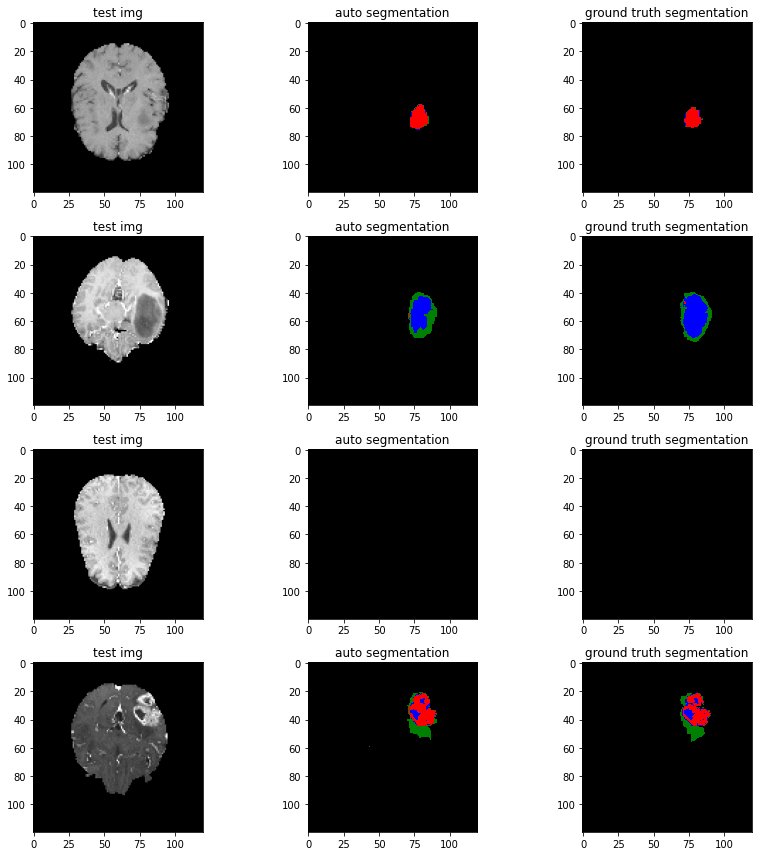

In [ ]:
### Insert your code ###
# load the final model
model.load_state_dict(torch.load(os.path.join(model_dir, 'model_10000.pt')))
model.eval()

# random batch of test images and corresponding labels
images, labels = test_set.get_random_batch(4)
images, labels = torch.from_numpy(images), torch.from_numpy(labels)
images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)

fig, axs = plt.subplots(4, 3, figsize=(12, 12))
for i in range(4):
    # ground truth for test image
    image = images[i].unsqueeze(0)
    label = labels[i]
    
    # auto segmentation for test image
    output = model(image)
    output = torch.argmax(output, dim=1).squeeze().detach().cpu().numpy()
    
    axs[i, 0].imshow(image.squeeze().detach().cpu().numpy(), cmap='gray')
    axs[i, 0].set_title('test img')

    axs[i, 1].imshow(output, cmap = colors.ListedColormap(['black', 'green', 'blue', 'red']))
    axs[i, 1].set_title('auto segmentation')

    axs[i, 2].imshow(label.cpu().numpy(), cmap = colors.ListedColormap(['black', 'green', 'blue', 'red']))
    axs[i, 2].set_title('ground truth segmentation')
    
plt.tight_layout()
plt.show()


### End of your code ###

## 6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?

The trained model works quite well and can correctly segment all 4 classes. The model is good at locating the shapes of both non-enhancing tumours as well as enhancing tumours. It can also distinguish between the two. However, when it comes to edemas, the model performs less well and sometimes the shape of the edema is close but not exactly correct. 


To improve the model so that it can be deployed to a real clinic, more training data could be used which would prevent the model from overfitting. Also, higher resolution images could be used, as this would produce better segmentation results which would be more useful for the medical staff.   